In [1]:
 !pip install transformers

     |████████████████████████████████| 3.8 MB 12.4 MB/s 
     |████████████████████████████████| 596 kB 10.8 MB/s 
     |████████████████████████████████| 895 kB 17.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.4 MB/s 
     |████████████████████████████████| 67 kB 2.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import collections
import math
import itertools

%matplotlib inline 

import torch
import torch.nn as nn
from torchtext import data
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
#from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm # for progress bar

Mounted at /content/drive


In [3]:
# if we want to run in GPU, set flag to True, else False for CPU
flag_gpu = True

device = torch.device('cuda' if (flag_gpu == True and torch.cuda.is_available()) else 'cpu')

In [4]:
path = '/content/drive/MyDrive/Colab_Notebooks/7_eksamino/AI/'

traindf = pd.read_csv(path + 'vs_train.csv')
valdf = pd.read_csv(path + 'vs_dev.csv')


## Preprocessing the tweets with distillBert tokenizer for sequence classification

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)

# ~~~~~ DEFINE MAX LENGTH OF EACH EMBEDDING ~~~~~ #
max_len = 60
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

In [6]:
# class for custom dataset
class myDataset(torch.utils.data.Dataset):

  def __init__(self, dataframe):
    new_df = dataframe['tweet'].apply(lambda x: '[CLS] ' + x + ' [SEP]')
    tokenized_text = new_df.apply(lambda x: tokenizer(x,padding='max_length', max_length = max_len, truncation=True, return_tensors="pt")).values
    self.labels = dataframe.label.values
    self.items = tokenized_text

  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self,idx):
    return self.items[idx], np.array(self.labels[idx])


In [8]:
# some functions for plots, nothing special, go to next cell
############################################################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

# function to compute learning curve and plot
def learning_curves(x_train, y_train, x_test, y_test, title_input):
  
  plt.plot(x_train, y_train, label = 'Training loss', linestyle = '-', marker='o')
  plt.plot(x_test, y_test, label = 'Validation loss',linestyle = '-', marker='o')

  #some visual add-ons
  plt.grid()
  plt.ylabel('loss', fontsize = 10)
  plt.xlabel('epoch', fontsize = 10)
  title = title_input
  plt.title(title, fontsize = 14, y = 1.03)
  plt.legend()
  #plt.ylim(0,1)
  plt.yticks(np.arange(0.0,1.0, 0.1))

def plot_roc_curve(fpr, tpr, roc_auc):
  lw = 2
  colors = itertools.cycle(["aqua", "darkorange", "cornflowerblue"])
  for i, color in zip(range(3), colors):
      plt.plot(
          fpr[i],
          tpr[i],
          color=color,
          lw=lw,
          label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
      )
  plt.plot([0.5,1], [0.5,1], color="gray", linestyle='dashed')
  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Some extension of Receiver operating characteristic to multiclass")
  plt.legend(loc="lower right")
  plt.show()


In [17]:
from sklearn.metrics import roc_curve, auc

#########################################
######   CLASSIFICATION FUNCTION   ######

def nn_loop(model, optimizer, traindf, valdf, epochs, batch_siz):
  
  train_dataset = myDataset(traindf)
  eval_dataset = myDataset(valdf)

  train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_siz, shuffle=True)
  eval = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_siz)

  losses_train = []
  losses_valid = []

  ########### epoch loop ##########
  for epoch in range(epochs):

    ##############
    # training
    ##############
    model.train()
    losses = 0
    for items, labels in tqdm(train):
      input = items['input_ids'].squeeze(1).to(device)
      attention_mask = items['attention_mask'].squeeze(1).to(device)
      labels = labels.to(device)

      model.zero_grad() # clear any previously calculated gradients

      #loss, logits = model(input, attention_mask=attention_mask, labels=labels)
      outputs = model(input, attention_mask=attention_mask, labels=labels)

      losses += outputs.loss.item()

      #Perform backpropagation starting from the loss calculated in this epoch
      outputs.loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      #Update net's weights based on the gradients calculated during backprop
      optimizer.step()

    # save loss for train in this epoch
    losses_train += [ losses / len(train)]

    ############
    # evaluation
    ############
    model.eval()
    losses=0
    y_label_valid = []
    y_pred_valid = []

    for items, labels in eval:

      input = items['input_ids'].squeeze(1).to(device)
      attention_mask = items['attention_mask'].squeeze(1).to(device)
      labels = labels.to(device)

      with torch.no_grad():

        outputs = model(input, attention_mask=attention_mask, labels=labels)

        logits = outputs.logits.detach().cpu()
        labels_cpu = labels.to('cpu')

        #y_pred_softmax = model.out_activ_fun(output)
        losses += outputs.loss.item()
        #if epoch == (epochs-1):
        y_label_valid += labels_cpu.tolist()
        y_pred_valid += logits.tolist()

    # save loss for valid in this epoch
    losses_valid += [losses / len(eval)]



  y_pred_arr = np.array([np.array(xi) for xi in y_pred_valid])
  y_test_arr = np.array(y_label_valid).astype(int)
  y_test_roc = np.zeros((y_test_arr.size, np.max(y_test_arr)+1))
  y_test_roc[np.arange(y_test_arr.size),y_test_arr] = 1

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_classes = y_pred_arr.shape[1]
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_arr[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  y_pred = [x.index(max(x)) for x in y_pred_valid]
  y_label = y_label_valid

  return losses_train, losses_valid, y_pred, y_label, fpr, tpr, roc_auc, epoch+1

  



def classify(traindf, valdf, model, lr=2e-5, epochs=2, batch_siz=16):
  plt.figure(figsize = (14,7))

  # use AdamW optimizer  
  optimizer = torch.optim.AdamW(model.parameters(), lr = lr, eps = 1e-8)

  train_losses, test_batch_losses, y_pred, y_label, fpr, tpr, roc_auc, iters = nn_loop(model, optimizer, traindf, valdf, epochs=epochs, batch_siz=batch_siz)

  x_axis = [i for i in range(iters)]

  plt.subplot(1,2,1)
  title = "loss vs epoch"
  learning_curves(x_axis, train_losses, x_axis, test_batch_losses, title)

  plt.subplot(1,2,2)
  plot_roc_curve(fpr,tpr,roc_auc)
  counter = [(x==1) for x in y_label]
  print(sum(counter))
  print(classification_report(y_label, y_pred, target_names=['Neutral', 'Anti-Vax', 'Pro-Vax']))



In [9]:
# define our model. I am currently using distillBert.
bertModel = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_attentions=False, output_hidden_states=False, num_labels=3)
# move it to gpu if needed
if flag_gpu and torch.cuda.is_available():
  bertModel.cuda()


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
# ~~~~~~~~~   HYPER-PARAMETERS   ~~~~~~~~~~ #
lr = 3e-5
epochs = 2
batch_siz = 32
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


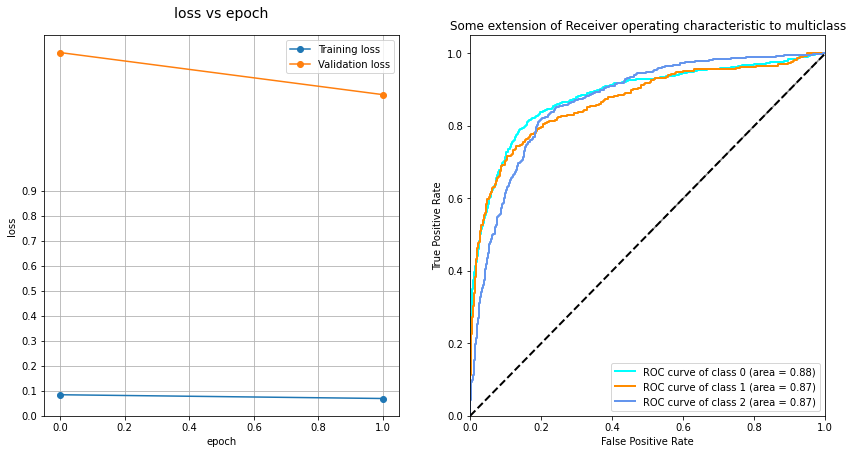

296
              precision    recall  f1-score   support

     Neutral       0.81      0.82      0.81      1065
    Anti-Vax       0.66      0.57      0.61       296
     Pro-Vax       0.75      0.77      0.76       921

    accuracy                           0.77      2282
   macro avg       0.74      0.72      0.73      2282
weighted avg       0.77      0.77      0.77      2282



In [18]:
classify(traindf, valdf, bertModel, lr, epochs, batch_siz)

In [15]:
lr = 2e-5
epochs = 2
batch_siz = 16
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
classify(traindf, valdf, bertModel, lr, epochs, batch_siz)

100%|██████████| 999/999 [06:33<00:00,  2.54it/s]


              precision    recall  f1-score   support

     Neutral       0.85      0.76      0.81      1065
    Anti-Vax       0.60      0.57      0.59       296
     Pro-Vax       0.72      0.82      0.77       921

    accuracy                           0.76      2282
   macro avg       0.73      0.72      0.72      2282
weighted avg       0.77      0.76      0.76      2282



<Figure size 1008x504 with 0 Axes>

In [16]:

lr = 5e-5
epochs = 2
batch_siz = 32
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
classify(traindf, valdf, bertModel, lr, epochs, batch_siz)

100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


              precision    recall  f1-score   support

     Neutral       0.80      0.82      0.81      1065
    Anti-Vax       0.70      0.53      0.60       296
     Pro-Vax       0.74      0.78      0.76       921

    accuracy                           0.77      2282
   macro avg       0.75      0.71      0.73      2282
weighted avg       0.77      0.77      0.76      2282



<Figure size 1008x504 with 0 Axes>

100%|██████████| 500/500 [05:14<00:00,  1.59it/s]


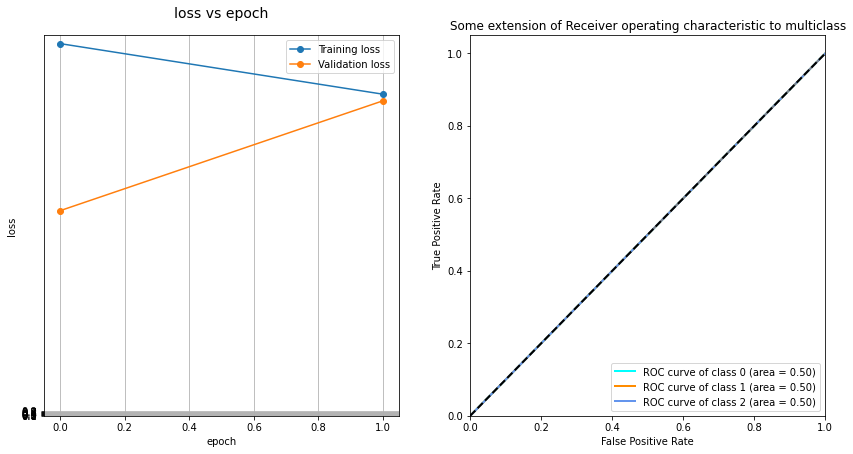

296
              precision    recall  f1-score   support

     Neutral       0.47      1.00      0.64      1065
    Anti-Vax       0.00      0.00      0.00       296
     Pro-Vax       0.00      0.00      0.00       921

    accuracy                           0.47      2282
   macro avg       0.16      0.33      0.21      2282
weighted avg       0.22      0.47      0.30      2282



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# ~~~~~~~~~  VERY LARGE LEARNING RATE   ~~~~~~~~~~ # 
lr = 5e-2     
epochs = 2
batch_siz = 32
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
classify(traindf, valdf, bertModel, lr, epochs, batch_siz)

100%|██████████| 250/250 [04:41<00:00,  1.12s/it]


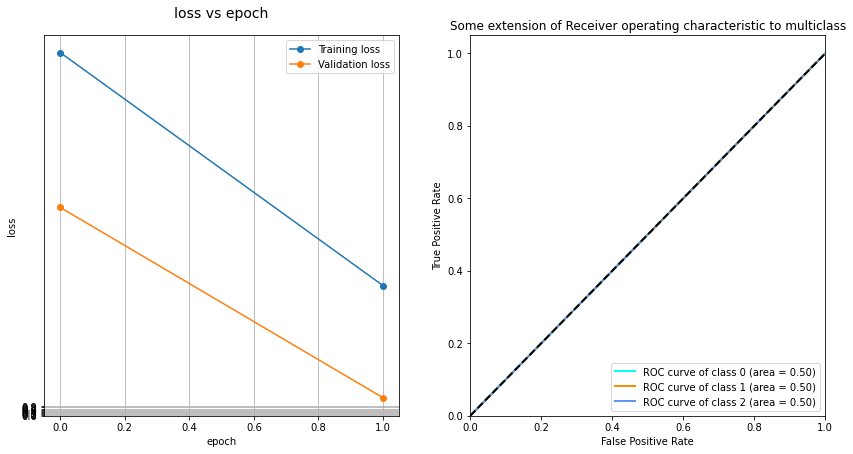

296
              precision    recall  f1-score   support

     Neutral       0.47      1.00      0.64      1065
    Anti-Vax       0.00      0.00      0.00       296
     Pro-Vax       0.00      0.00      0.00       921

    accuracy                           0.47      2282
   macro avg       0.16      0.33      0.21      2282
weighted avg       0.22      0.47      0.30      2282



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# ~~~~~~~~~   HYPER-PARAMETERS   ~~~~~~~~~~ #
lr = 5e-4
epochs = 2
batch_siz = 64
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
classify(traindf, valdf, bertModel, lr, epochs, batch_siz)